In [1]:
import os

In [2]:
print(os.getcwd())

/tf/home/sergio/Tesis/TinyYOLOv3-Pedestrian-Detection/Dataset Preprocessing


In [3]:
root_path = "/tf/home/sergio/Tesis"

In [4]:
import sys
sys.path.append(root_path+"/TinyYOLOv3-Pedestrian-Detection")
from YOLOblocks import TinyYOLOv3,BasicBlock,PredictionLayer#,YOLOLossBasicBlock

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

from skimage.io import imread,imshow
from skimage.transform import resize
import time
import os

from pycocotools.coco import COCO

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
tf.__version__


'2.3.0'

In [7]:
def get_iou_matrix_tf(box_arr1, box_arr2):
    #print(box_arr1)
    #print(box_arr2)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    #print(xA)
    yA = tf.maximum(y11, tf.transpose(y21))
    #print(yA)
    xB = tf.minimum(x12, tf.transpose(x22))
    #print(xB)
    yB = tf.minimum(y12, tf.transpose(y22))
    #print(yB)
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    #print("interseccion",interArea)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    #print("area gt",boxAArea)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    #print("area pre",boxBArea)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    #print(iou)
    return tf.cast(iou>=0.5,dtype=tf.int32),iou

In [8]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end

    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [9]:
os.chdir(root_path+"/COCODataset/coco_csvs")
annotations_val_set = pd.read_csv("COCO_annotations_val.csv")
annotations_val_set.drop("Unnamed: 0",axis=1)

,file_name,xmin,ymin,xmax,ymax
0,000000532481.jpg,0.391906,0.394977,0.501453,0.547277
1,000000532481.jpg,0.446172,0.869859,0.465031,0.914953
2,000000458755.jpg,0.107859,0.078646,0.901687,0.986521
3,000000458755.jpg,0.885938,0.002646,1.000000,0.183604
4,000000458755.jpg,0.921906,0.191021,0.999437,0.393250
...,...,...,...,...,...
10999,000000098287.jpg,0.870193,0.408687,0.882000,0.440844
11000,000000098287.jpg,0.419277,0.389062,0.455422,0.418750
11001,000000417779.jpg,0.736297,0.178083,0.765656,0.267104
11002,000000024567.jpg,0.000000,0.000000,0.876958,0.745188


In [10]:
metadata_val_set = pd.read_csv("COCO_metadata_val.csv",index_col=0)

In [11]:
metadata_val_set

,width,height
000000532481.jpg,640,426
000000458755.jpg,640,480
000000385029.jpg,640,480
000000311303.jpg,640,427
000000393226.jpg,640,480
...,...,...
000000229358.jpg,640,423
000000098287.jpg,415,640
000000417779.jpg,640,480
000000024567.jpg,480,640


In [19]:
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")
#validation_images_names = os.listdir()
validation_images_names = list(metadata_val_set.index.values)
print(len(validation_images_names))

2693


In [20]:
detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","TP","FP","cum TP","cum FP","precision","recall"])

In [113]:
#anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]
anchors =[[0.02078,0.049],[0.0426,0.128],[0.08523,0.19356],[0.1506,0.4163],[0.27835,0.58651],[0.5632,0.78614]]
#anchors =tf.constant(np.array([[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]),dtype=tf.float32)

#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)

model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model.build(batch_input_shape=(None,416,416,3))

#MSLE NUEVO ENTRENAMIENTO
#model.load_weights(root_path+'/weights_saved/pesos_1441_20_30_epoch_nadam_0dot00003_mse_msle_2anchors')

#model.load_weights_darknet("/home/sergio/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights"))

'''Pesos con msle y mse del exponencial con dos anchors epochs_50 =0.096; epochs_70 = 0.096, epoch_140 = 0.091'''
#model.load_weights(root_path+'/weights_saved/pesos_1441_130_to_140_epoch_nadam_0dot000001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse')

'''Pesos con msle en ambos losses '''
#model.load_weights(root_path+'/weights_saved/pesos_10_60_epochs_nadam_1_2_4_1_0dot001_msle')
#model.load_weights(root_path+'/weights_saved/pesos_60_80_epochs_nadam_1_2_4_1_0dot0001_msle')
#model.load_weights(root_path+'/weights_saved/pesos_80_100_epochs_nadam_1_2_4_1_0dot0001_msle')
#model.load_weights(root_path+'/weights_saved/pesos_80_100_epochs_nadam_1_4_4_1_0dot0001_msle')
#model.load_weights(root_path+'/weights_saved/pesos_100_120_epochs_nadam_1_4_4_1_0dot00001_msle')

'''Pesos con mse pero por muchas epocas 0.07'''
#model.load_weights(root_path+'/weights_saved/pesos_160_to_180_epochs_nadam_2_1_4_1_0dot0001_el_bueno')
#model.load_weights(root_path+'/weights_saved/pesos_50_epochs_nadam_2_1_4_1_0dot001_el_bueno')
#model.load_weights(root_path+'/weights_saved/pesos_50_to_80_epochs_nadam_2_1_4_1_0dot001_el_bueno')
#model.load_weights(root_path+'/weights_saved/pesos_80_to_90_epochs_nadam_2_1_4_1_0dot001_el_bueno')
#model.load_weights(root_path+'/weights_saved/pesos_90_to_140_epochs_nadam_2_1_4_1_0dot001_el_bueno')
#model.load_weights(root_path+'/weights_saved/pesos_140_to_160_epochs_nadam_2_1_4_1_0dot001_el_bueno')

##########
'''Transfer learning sin data augmentation con 2 anchors y pesos 5521 20m epocas'''
#model.load_weights(root_path+'/weights_saved/pesos_5521_20_epoch_nadam_0dot00001_mse_2anchors')

'''Transfer learning sin data augmentation con 3 anchors y pesos 5521 20m epocas'''
#model.load_weights(root_path+'/weights_saved/pesos_5521_20_epoch_nadam_0dot00001_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_5521_20_30_epoch_nadam_0dot00001_mse_2anchors_tl') #es con 3 anchors
#model.load_weights(root_path+'/weights_saved/pesos_5521_30_40_epoch_nadam_0dot00001_mse_3anchors_tl') #es con 3 anchors
#model.load_weights(root_path+'/weights_saved/pesos_5521_40_50_epoch_nadam_0dot000001_mse_3anchors_tl') #es con 3 anchors

#model.load_weights(root_path+'/weights_saved/pesos_transfer_learning_5521_20_epoch_nadam_0dot00001_mse_3anchors_con_data_aug')

'''3 anchors con MSE puro es TRANSFER LEARNING CON DATA AUGMENTATION'''
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_20_epoch_nadam_0dot00001_mse_3anchors')
##########

'''2 anchors co nadam y msle y exp msecon 1241 de lambdas'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_70_to_90_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1241_90_to_110_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1441_110_to_130_epoch_nadam_0dot000001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1441_130_to_140_epoch_nadam_0dot000001_msle_exp_mse')




'''3 anchors 50 epocas con pesos 1241, posiblemente experimento fallido, y con losses msle y mse del exponencial epochs_50 = 0.10452790882585117'''
#model.load_weights(root_path+'/weights_saved/pesos_1241_20_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_1241_20_30_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_1241_30_50_epoch_nadam_0dot00001_msle_exp_mse_3anchors')



'''3 anchors 50 epocas con pesos 5521, posiblemente mejor resultado, y con losses msle y mse del exponencial epochs_30 = 0.12125929824973192, epoch_50 = 0.1228'''
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_10_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_10_30_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_30_50_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_1e-5_msle_exp_mse_3anchors_NUEVO_TRAIN')


#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_1_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_30_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_30_50_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_50_80_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_80_100_epoch_nadam_0dot00001_mse_exp_mse_3anchors')

'''MEJOR RESULTADO CON 6 ANCHORS'''
model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_100_120_epoch_nadam_0dot00001_mse_exp_mse_3anchors')


'''los 3 anchors por default 180 epocas'''
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_40_60_epoch_nadam_0dot00001_mse_mse_default_anchors')
#mdel.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_20_40_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_60_80_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_80_100_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_100_120_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_120_140_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_140_160_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_160_180_epoch_nadam_0dot00001_mse_mse_default_anchors')

'''traning_k_6_mse_mse-con-data_aug-1111'''
#model.load_weights(root_path+'/last_weights/pesos_finetuning_2211_70_80_epoch_nadam_0dot00001_mse_exp_mse_3anchors_con_data_aug')
#model.load_weights(root_path+'/last_weights/pesos_finetuning_2211_90_100_epoch_nadam_0dot00001_mse_exp_mse_3anchors_con_data_aug')
#model.load_weights(root_path+'/last_weights/pesos_finetuning_2211_80_90_epoch_nadam_0dot00001_mse_exp_mse_3anchors_con_data_aug_diff')


'''training mse y exp mse sin data augmentation con 5521'''
#model.load_weights(root_path+'/last_weights/pesos_finetuning_5521_30_50_epoch_nadam_0dot00001_mse_exp_mse_3anchors_final_experiment')



'''training mse y exp mse con data augmentation con 5521'''
#model.load_weights(root_path+'/last_weights/pesos_finetuning_5521_40_60_epoch_nadam_0dot00001_mse_exp_mse_3anchors_final_experiment_con_data_aug')
'''
Precision: 0.8557794
Recall: 0.14667393
F1: 0.25042668436349286
Corrected detected objects 1614
AP: 0.13497617243528337
'''


'''training mse y exp mse con data augmentation 1121'''
#model.load_weights(root_path+'/last_weights/pesos_finetuning_1121_70_80_epoch_nadam_0dot00001_mse_mse_3anchors_con_data_aug')
#model.load_weights(root_path+'/last_weights/pesos_finetuning_1121_80_90_epoch_nadam_0dot00001_mse_mse_3anchors_con_data_aug')
#model.load_weights(root_path+'/last_weights/pesos_finetuning_1121_90_100_epoch_nadam_0dot00001_mse_mse_3anchors_con_data_aug')
#model.load_weights(root_path+'/last_weights/pesos_finetuning_1121_100_110_epoch_nadam_0dot00001_mse_mse_3anchors_con_data_aug')


'training mse y exp mse con data augmentation 1121'

## Evaluación de mis modelos

In [114]:
import numpy as np
def yxyx_to_yxwh(bbox):
    x_min,y_min,x_max,y_max=np.split(bbox,4,axis=0)
    
    width = x_max-x_min
    height = y_max-y_min
    x_center = x_min + (width/2)
    y_center = y_min + (height/2)
    
    out = np.concatenate((x_center,y_center,width,height))
    
    return out

def errors(bbox_pred,bbox_gt):
    
    bbox_pred = yxyx_to_yxwh(bbox_pred)
    bbox_gt = yxyx_to_yxwh(bbox_gt)
    
    xy_error = np.square(bbox_pred[0]-bbox_gt[0]) + np.square(bbox_pred[1]-bbox_gt[1]) 
    wh_error = np.square(bbox_pred[3]-bbox_gt[3]) + np.square(bbox_pred[2]-bbox_gt[2])
    
    return (xy_error,wh_error)

In [115]:
bbox_prueba = np.array([50,30,120,150])

In [116]:
yxyx_to_yxwh(bbox_prueba)

array([ 85.,  90.,  70., 120.])

In [117]:
inicio = time.time()
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")

detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","xy_error","wh_error","TP","FP"])
results_eval = []
obj_thresh = 0.5

nms = True

for image in validation_images_names:
    #print(image)
    annotations_images_df = annotations_val_set[annotations_val_set.file_name==image]

    image_height = metadata_val_set.loc[image]["height"]
    image_width = metadata_val_set.loc[image]["width"]
    
    groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
    groud_truth_bboxes[:,[0,2]] = groud_truth_bboxes[:,[0,2]]#*image_width
    groud_truth_bboxes[:,[1,3]] = groud_truth_bboxes[:,[1,3]]#*image_height
    
    img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    
    if not nms:
        outputs = model(img).numpy()[0,:,:];

        predicted_boxes =np.abs(outputs[outputs[:,-1] >= obj_thresh])[:,:4]
        scores = np.abs(outputs[outputs[:,-1] >= obj_thresh])[:,4]
        #print(predicted_boxes)
        predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
        predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height
        
    else:
        #scores
        boxes,scores = model(img);
        #outputs = model(img)
        #print(outputs)
        #print(indices.numpy())
        #print(boxes.numpy().shape)
        
        predicted_boxes = np.clip(boxes.numpy()[0,:,:],0,1)#[indices.numpy(),:]
        scores =scores.numpy()

        #predicted_boxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:]
        #scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()] 
        
        
        predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
        predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height
        
    for box,score in zip(predicted_boxes,scores):

        iou_resulted,iou = get_iou_matrix_tf(groud_truth_bboxes, box[tf.newaxis,:])
        
        if np.sum(iou_resulted) >= 1:
            tp = 1
            fp = 0
            which_gt = np.argmax(iou)
            iou_value = np.max(iou)
            #print(iou_value)
            coord_gt = groud_truth_bboxes[which_gt,:]
            
            xy_error,wh_error = errors(box,coord_gt)
            
            groud_truth_bboxes=np.delete(groud_truth_bboxes,which_gt,axis=0)
        #NO hay algún ground truth con el que tenga mas de 0.5 de IoU    
        elif np.sum(iou_resulted) == 0:
            fp = 1
            tp = 0
            
            
            #EL objeto predicho de plano no machea con ninǵún ground truth
            if iou.shape[0]>0  and np.sum(iou)==0:
                iou_value=0
                xy_error=-1
                wh_error=-1    
            #EL objeto predicho hizo match con algún ground truth pero no lo suficiente paara ser un TP    
            elif iou.shape[0]>0  and np.sum(iou)>0:
                
                iou_value = np.max(iou)
                which_gt = np.argmax(iou)
                coord_gt = groud_truth_bboxes[which_gt,:]
                xy_error,wh_error = errors(box,coord_gt)                
                
            # La red detecto un objecto donde ya no hay groudn truth 
            elif iou.shape[0]==0:
                
                iou_value=0
                xy_error=-2
                wh_error=-2     

        predicted_dict = {"file_name":[image],"xmin":[box[0]],"ymin":[box[1]],"xmax":[box[2]],"ymax":[box[3]],"score":[score],
                          "xy_error":[xy_error],"wh_error":[wh_error],"iou":[iou_value],"TP":[tp],"FP":[fp]}
        
        aux = pd.DataFrame(predicted_dict)
        detections_df = pd.concat((detections_df,aux),ignore_index=True)
        #print(aux)        
        
        #print(groud_truth_bboxes)
        #print(iou)

detections_df = detections_df.sort_values(by="score",ascending=False)
cum_tp = np.cumsum(detections_df["TP"].values)
cum_fp = np.cumsum(detections_df["FP"].values)
detections_df.insert(detections_df.shape[1],"cum TP",cum_tp)
detections_df.insert(detections_df.shape[1],"cum FP",cum_fp)
detections_df["Precision"]= (detections_df.loc[:,"cum TP"]/(detections_df.loc[:,"cum TP"] + detections_df.loc[:,"cum FP"])).astype(np.float32)
detections_df["Recall"]= (detections_df.loc[:,"cum TP"]/11004).astype(np.float32)
detections_df["FP"]=detections_df["FP"].astype(np.int32)
detections_df["TP"]=detections_df["TP"].astype(np.int32)
detections_df["xy_error"] = detections_df["xy_error"].astype(np.float32)
detections_df["wh_error"] = detections_df["wh_error"].astype(np.float32)
fin = time.time()
print(fin-inicio)

53.24849987030029


In [118]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
1489,000000559842.jpg,0.743972,0.339459,0.857438,0.746418,0.999998,0.000718,0.002778,1,0,0.747773,1,0,1.000000,0.000091
1809,000000216296.jpg,0.480169,0.006170,0.618323,0.386322,0.999948,0.000750,0.000032,1,0,0.660039,2,0,1.000000,0.000182
2244,000000323799.jpg,0.581002,0.263253,0.703770,0.741898,0.999923,0.000004,0.000205,1,0,0.935711,3,0,1.000000,0.000273
116,000000057597.jpg,0.813451,0.312248,0.960474,0.659337,0.999903,0.000055,0.000083,1,0,0.899746,4,0,1.000000,0.000364
1239,000000059635.jpg,0.355499,0.170107,0.511371,0.533397,0.999898,0.000351,0.002991,1,0,0.678627,5,0,1.000000,0.000454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,000000257566.jpg,0.388805,0.236340,0.424325,0.357725,0.500512,0.000344,0.003302,0,1,0.321055,2893,1395,0.674673,0.262904
277,000000549390.jpg,0.291121,0.169906,0.578895,0.869067,0.500449,0.001453,0.001689,1,0,0.796074,2894,1395,0.674749,0.262995
4000,000000490936.jpg,0.455849,0.162589,0.483670,0.235058,0.500250,0.000051,0.000044,1,0,0.536381,2895,1395,0.674825,0.263086
1024,000000067406.jpg,0.749914,0.749281,0.763947,0.794428,0.500231,0.000133,0.000096,0,1,0.201625,2895,1396,0.674668,0.263086


In [119]:
final_p = detections_df.Precision.iloc[-1]
final_r = detections_df.Recall.iloc[-1]
f1_score = (2*final_p*final_r)/(final_p+final_r)

In [120]:
detections_df[detections_df.iou != 0][detections_df.FP==1].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,1099.000000,1.099000e+03,1.099000e+03,1099.000000
mean,0.693771,2.609309e-02,1.761866e-01,0.239667
std,0.139486,5.433514e-02,3.623576e-01,0.167490
min,0.500231,8.231675e-07,2.497253e-07,0.000365
25%,0.569562,2.363389e-04,3.579050e-04,0.064354
50%,0.664921,1.875222e-03,4.863049e-03,0.250339
75%,0.801572,1.822909e-02,7.813584e-02,0.397746
max,0.999187,3.505166e-01,1.707879e+00,0.499327


In [121]:
detections_df[detections_df.iou != 0][detections_df.FP==0].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,2895.000000,2.895000e+03,2.895000e+03,2895.000000
mean,0.783679,1.034446e-03,4.151932e-03,0.737460
std,0.153174,3.123341e-03,1.208531e-02,0.113717
min,0.500250,7.527692e-08,1.567773e-08,0.500267
25%,0.648435,5.633733e-05,2.364672e-04,0.651392
50%,0.799638,1.865547e-04,8.295793e-04,0.749155
75%,0.924059,6.320515e-04,2.876338e-03,0.829916
max,0.999998,4.715346e-02,1.931725e-01,0.981121


In [122]:
detections_df[detections_df.iou == 0]

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
414,000000295713.jpg,0.140548,0.176314,0.372554,0.837546,0.998958,-1.0,-1.0,0,1,0.0,39,2,0.951219,0.003544
2993,000000529939.jpg,0.128935,0.220557,0.277681,0.815796,0.991471,-1.0,-1.0,0,1,0.0,182,8,0.957895,0.016539
4031,000000458223.jpg,0.214510,0.365682,0.224187,0.388417,0.989005,-1.0,-1.0,0,1,0.0,211,13,0.941964,0.019175
71,000000032941.jpg,0.106661,0.297561,0.128162,0.354043,0.986927,-1.0,-1.0,0,1,0.0,228,17,0.930612,0.020720
572,000000566282.jpg,0.848184,0.442008,0.867776,0.541421,0.970173,-1.0,-1.0,0,1,0.0,399,38,0.913043,0.036260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399,000000455219.jpg,0.538229,0.497374,0.562740,0.534228,0.503947,-1.0,-1.0,0,1,0.0,2876,1379,0.675911,0.261360
936,000000206487.jpg,0.395077,0.420021,0.420785,0.464309,0.503782,-1.0,-1.0,0,1,0.0,2877,1381,0.675669,0.261450
162,000000074058.jpg,0.589107,0.489752,0.604457,0.542109,0.502846,-1.0,-1.0,0,1,0.0,2883,1386,0.675334,0.261996
2529,000000258793.jpg,0.697283,0.799068,0.784680,1.000000,0.501122,-1.0,-1.0,0,1,0.0,2891,1394,0.674679,0.262723


In [123]:
#0.533149	0.157852

In [124]:
print("Objetos detectados que no correspondieron a algún GT",len(detections_df[detections_df.xy_error == -1]))
print("Objetos detectados donde ya no habían GT",len(detections_df[detections_df.xy_error == -2]))
print("Total:",len(detections_df[detections_df.xy_error == -1])+len(detections_df[detections_df.xy_error == -2]) )

Objetos detectados que no correspondieron a algún GT 272
Objetos detectados donde ya no habían GT 26
Total: 298


Tomamos en cuenta solamente los bouding box que si tienen algun IoU con un ground truth

In [125]:
detections_df[detections_df.iou != 0].loc[:,["score","xy_error","wh_error","iou"]].describe()

,score,xy_error,wh_error,iou
count,3994.000000,3.994000e+03,3.994000e+03,3994.000000
mean,0.758940,7.929651e-03,5.148946e-02,0.600486
std,0.154815,3.072737e-02,2.052220e-01,0.257918
min,0.500231,7.527692e-08,1.567773e-08,0.000365
25%,0.618081,7.703839e-05,2.605442e-04,0.463820
50%,0.761086,2.801955e-04,1.080149e-03,0.678657
75%,0.898618,1.430022e-03,5.322619e-03,0.796588
max,0.999998,3.505166e-01,1.707879e+00,0.981121


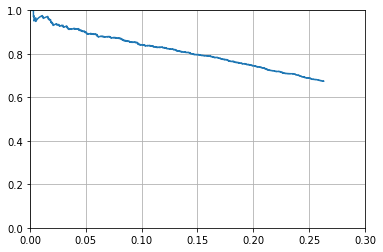

In [126]:
plt.plot(detections_df["Recall"],detections_df["Precision"])
plt.ylim([0,1])
plt.xlim([0,0.3])
plt.grid()

In [127]:
#90 epocas

print("Precision:", detections_df.Precision.iloc[-1])
print("Recall:",detections_df.Recall.iloc[-1])
print("F1:",f1_score)
print("Corrected detected objects",detections_df["cum TP"].iloc[-1])
print("AP:",compute_ap(detections_df["Recall"].values, detections_df["Precision"].values))

Precision: 0.6745107
Recall: 0.26308614
F1: 0.37853032399551934
Corrected detected objects 2895
AP: 0.21516299809889008


In [65]:
#80 epocas

print("Precision:", detections_df.Precision.iloc[-1])
print("Recall:",detections_df.Recall.iloc[-1])
print("F1:",f1_score)
print("Corrected detected objects",detections_df["cum TP"].iloc[-1])
print("AP:",compute_ap(detections_df["Recall"].values, detections_df["Precision"].values))

Precision: 0.61230594
Recall: 0.29752818
F1: 0.4004647899018003
Corrected detected objects 3274
AP: 0.2295953255892168


In [50]:
print("Precision:", detections_df.Precision.iloc[-1])
print("Recall:",detections_df.Recall.iloc[-1])
print("F1:",f1_score)
print("Corrected detected objects",detections_df["cum TP"].iloc[-1])
print("AP:",compute_ap(detections_df["Recall"].values, detections_df["Precision"].values))

Precision: 0.6375839
Recall: 0.27626318
F1: 0.38549328302413566
Corrected detected objects 3040
AP: 0.2186564821705957


In [105]:
#os.chdir("/tf/home/sergio/Tesis")
#detections_df.to_csv("detections_df_best_result_3_anchors")

In [ ]:
#transfer learning 6 anchors

Precision: 0.7282353
Recall: 0.16875681
F1: 0.2740150569233084
AP: 0.13861899394426186
    
#TRanfer learning 4 anchors

Precision: 0.7059841
Recall: 0.185478
F1: 0.2937747435459664
AP: 0.14862202995322918

In [ ]:
Precision: 0.612132
Recall: 0.281534
F1: 0.3856831526506761
AP: 0.20259784556734722

In [119]:
#os.chdir("/tf/home/sergio/")
#detections_df.to_csv("detections_df_best_result_2_anchors")

In [33]:
groud_truth_bboxes

array([[0.35090625, 0.29288056, 0.6325469 , 0.60215455],
       [0.091875  , 0.010726  , 0.3222969 , 0.24775176],
       [0.6431875 , 0.23480093, 0.8530313 , 0.621897  ],
       [0.05910937, 0.2788056 , 0.3239375 , 0.68775177],
       [0.0294375 , 0.84833723, 0.31775   , 1.        ],
       [0.        , 0.        , 0.10660937, 0.20800936],
       [0.7616875 , 0.6992506 , 0.9873594 , 1.        ],
       [0.40107813, 0.12461358, 0.55575   , 0.30166277],
       [0.13801563, 0.        , 0.3299375 , 0.20913349],
       [0.373875  , 0.01030445, 0.55842185, 0.2622014 ]], dtype=float32)

In [34]:
groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)

In [35]:
groud_truth_bboxes

array([[0.35090625, 0.29288056, 0.6325469 , 0.60215455],
       [0.091875  , 0.010726  , 0.3222969 , 0.24775176],
       [0.04420312, 0.4626698 , 0.37975   , 0.852178  ],
       [0.6431875 , 0.23480093, 0.8530313 , 0.621897  ],
       [0.05910937, 0.2788056 , 0.3239375 , 0.68775177],
       [0.0294375 , 0.84833723, 0.31775   , 1.        ],
       [0.        , 0.        , 0.10660937, 0.20800936],
       [0.7616875 , 0.6992506 , 0.9873594 , 1.        ],
       [0.40107813, 0.12461358, 0.55575   , 0.30166277],
       [0.13801563, 0.        , 0.3299375 , 0.20913349],
       [0.373875  , 0.01030445, 0.55842185, 0.2622014 ]], dtype=float32)

In [36]:
import cv2
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    #x_center, y_center, width, height = bbox#*416
    x_min,y_min,x_max,y_max=bbox
    #x_min = int(x_center-(width//2))
    #y_min = int(y_center-(height//2))
    #x_max = int(x_center+(width//2))
    #y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    #class_name = class_idx_to_name[class_id]
    #((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    #cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)

In [37]:
predicted_boxes

array([[0.00645505, 0.43281224, 0.3059324 , 0.9556439 ]], dtype=float32)

In [38]:
annotations_val_set[annotations_val_set.file_name == image]

,Unnamed: 0,file_name,xmin,ymin,xmax,ymax
10387,10387,000000089648.jpg,0.350906,0.292881,0.632547,0.602155
10388,10388,000000089648.jpg,0.091875,0.010726,0.322297,0.247752
10389,10389,000000089648.jpg,0.044203,0.462670,0.379750,0.852178
10390,10390,000000089648.jpg,0.643188,0.234801,0.853031,0.621897
10391,10391,000000089648.jpg,0.059109,0.278806,0.323937,0.687752
10392,10392,000000089648.jpg,0.029437,0.848337,0.317750,1.000000
10393,10393,000000089648.jpg,0.000000,0.000000,0.106609,0.208009
10394,10394,000000089648.jpg,0.761688,0.699251,0.987359,1.000000
10395,10395,000000089648.jpg,0.401078,0.124614,0.555750,0.301663
10396,10396,000000089648.jpg,0.138016,0.000000,0.329937,0.209133


In [39]:
detections_df[detections_df.file_name == "000000397354.jpg"]
predicted_boxes = (detections_df[detections_df.file_name == "000000397354.jpg"].iloc[:,1:5]).values
print(predicted_boxes)

[[0.45456153 0.4155961  0.78897053 0.97896111]
 [0.73367381 0.47048101 0.97383416 0.92967391]
 [0.16766775 0.28544822 0.30397451 0.6414119 ]
 [0.47976625 0.34020919 0.60963249 0.74175316]]


In [41]:
img_raw = tf.image.decode_image(open("000000397354.jpg", 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = tf.image.resize(img, (416, 416))/255
    
#visualize(resize(img.numpy()[0,:,:,:],(image_height,image_width)),predicted_boxes)

In [42]:
print(np.mean(detections_df["Precision"]))

0.53034025


## Evaluación del modelo original YOLO

In [14]:
anchors =[[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]
#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
model = TinyYOLOv3(80,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model.build(batch_input_shape=(None,416,416,3))
model.load_weights_darknet(root_path+"/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights")
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')

Pesos de la convolucion (432,)
CONV SHAPE (16, 3, 3, 3)
496
Pesos de la convolucion (4608,)
CONV SHAPE (32, 16, 3, 3)
5232
Pesos de la convolucion (18432,)
CONV SHAPE (64, 32, 3, 3)
23920
Pesos de la convolucion (73728,)
CONV SHAPE (128, 64, 3, 3)
98160
Pesos de la convolucion (294912,)
CONV SHAPE (256, 128, 3, 3)
394096
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
1575792
Pesos de la convolucion (4718592,)
CONV SHAPE (1024, 512, 3, 3)
6298480
Pesos de la convolucion (262144,)
CONV SHAPE (256, 1024, 1, 1)
6561648
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
7743344
Pesos de la convolucion (130560,)
CONV SHAPE (255, 512, 1, 1)
7874159
Pesos de la convolucion (32768,)
CONV SHAPE (128, 256, 1, 1)
7907439
Pesos de la convolucion (884736,)
CONV SHAPE (256, 384, 3, 3)
8793199
Pesos de la convolucion (65280,)
CONV SHAPE (255, 256, 1, 1)
8858734
8858734
8858734
8858734
8858734
8858734
8858734


8858734

In [17]:
inicio = time.time()
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")

detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","TP","FP"])
results_eval = []
obj_thresh = 0.3

for image in validation_images_names:
    #print(image)
    annotations_images_df = annotations_val_set[annotations_val_set.file_name==image]

    image_height = metadata_val_set.loc[image]["height"]
    image_width = metadata_val_set.loc[image]["width"]
    
    groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
    groud_truth_bboxes[:,[0,2]] = groud_truth_bboxes[:,[0,2]]#*image_width
    groud_truth_bboxes[:,[1,3]] = groud_truth_bboxes[:,[1,3]]#*image_height
    
    img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    
    outputs = model(img);
    

    real_outputs = outputs[2].numpy()[0,0:outputs[3][0].numpy()]
    person_index = np.where(real_outputs ==0)
    #print(person_index)
    #person_outputs 
    predicted_boxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:][person_index,:][0,:,:]
    scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()][person_index]
        
    #print(predicted_boxes.shape)
    #print(scores.shape)
    
    predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
    predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height

    for box,score in zip(predicted_boxes,scores):

        iou_resulted,iou = get_iou_matrix_tf(groud_truth_bboxes, box[tf.newaxis,:])
        
        if np.sum(iou_resulted) >= 1:
            tp = 1
            fp = 0
            which_gt = np.argmax(iou)
            iou_value = np.max(iou)
            #print(iou_value)
            coord_gt = groud_truth_bboxes[which_gt,:]
            
            xy_error,wh_error = errors(box,coord_gt)
            
            groud_truth_bboxes=np.delete(groud_truth_bboxes,which_gt,axis=0)
        #NO hay algún ground truth con el que tenga mas de 0.5 de IoU    
        elif np.sum(iou_resulted) == 0:
            fp = 1
            tp = 0
            
            
            #EL objeto predicho de plano no machea con ninǵún ground truth
            if iou.shape[0]>0  and np.sum(iou)==0:
                iou_value=0
                xy_error=-1
                wh_error=-1    
            #EL objeto predicho hizo match con algún ground truth pero no lo suficiente paara ser un TP    
            elif iou.shape[0]>0  and np.sum(iou)>0:
                
                iou_value = np.max(iou)
                which_gt = np.argmax(iou)
                coord_gt = groud_truth_bboxes[which_gt,:]
                xy_error,wh_error = errors(box,coord_gt)                
                
            # La red detecto un objecto donde ya no hay groudn truth 
            elif iou.shape[0]==0:
                
                iou_value=0
                xy_error=-2
                wh_error=-2     

        predicted_dict = {"file_name":[image],"xmin":[box[0]],"ymin":[box[1]],"xmax":[box[2]],"ymax":[box[3]],"score":[score],
                          "xy_error":[xy_error],"wh_error":[wh_error],"iou":[iou_value],"TP":[tp],"FP":[fp]}
        aux = pd.DataFrame(predicted_dict)
        detections_df = pd.concat((detections_df,aux),ignore_index=True)
        #print(aux)        
        
        #print(groud_truth_bboxes)
        #print(iou)
    '''
    x_min,y_min,x_max,y_max =np.split(predicted_boxes,4,axis=1)
    x_min,x_max = x_min*image_width,x_max*image_width
    y_min,y_max = y_min*image_height,y_max*image_height
    
    width = x_max-x_min
    height = y_max-y_min
    x_global =x_min + tf.math.divide(x_max - x_min,2)
    y_global =y_min + tf.math.divide(y_max - y_min,2)    
    '''
detections_df = detections_df.sort_values(by="score",ascending=False)
cum_tp = np.cumsum(detections_df["TP"].values)
cum_fp = np.cumsum(detections_df["FP"].values)
detections_df.insert(detections_df.shape[1],"cum TP",cum_tp)
detections_df.insert(detections_df.shape[1],"cum FP",cum_fp)
detections_df["Precision"]= detections_df.loc[:,"cum TP"]/(detections_df.loc[:,"cum TP"] + detections_df.loc[:,"cum FP"])
detections_df["Recall"]= detections_df.loc[:,"cum TP"]/11004

fin = time.time()
print(fin-inicio)

53.80458354949951


In [18]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,TP,FP,xy_error,wh_error,iou,cum TP,cum FP,Precision,Recall
2301,000000038210.jpg,0.150684,0.427492,0.500176,0.880573,0.999887,1,0,0.000590,0.001437,0.828073,1,0,1,9.0876e-05
1513,000000427160.jpg,0.000000,0.415472,0.442092,1.000000,0.998726,1,0,0.000593,0.002429,0.846520,2,0,1,0.000181752
2489,000000213171.jpg,0.360051,0.287187,0.665166,0.884630,0.998278,1,0,0.000249,0.000128,0.895790,3,0,1,0.000272628
2762,000000133567.jpg,0.036695,0.486220,0.204128,1.000000,0.997423,1,0,0.000227,0.000776,0.856954,4,0,1,0.000363504
1737,000000188465.jpg,0.361481,0.542928,0.518214,0.826184,0.996834,1,0,0.000022,0.000430,0.889355,5,0,1,0.00045438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,000000092939.jpg,0.467950,0.178509,0.847671,0.787454,0.500404,1,0,0.000779,0.015901,0.706358,1743,1527,0.533028,0.158397
1632,000000451144.jpg,0.581005,0.398370,0.704933,0.796472,0.500340,1,0,0.000041,0.000223,0.875573,1744,1527,0.53317,0.158488
128,000000392722.jpg,0.500435,0.650183,0.535096,0.707777,0.500196,0,1,0.000061,0.008848,0.339056,1744,1528,0.533007,0.158488
742,000000233771.jpg,0.765753,0.702676,0.832660,0.944235,0.500133,0,1,0.022561,0.015457,0.058645,1744,1529,0.532844,0.158488


In [19]:
os.chdir("/tf/home/sergio/")
detections_df.to_csv("detections_df_original")

In [20]:
detections_df[detections_df.iou != 0].loc[:,["score","xy_error","wh_error","iou"]].describe()

,score,xy_error,wh_error,iou
count,3095.000000,3.095000e+03,3.095000e+03,3095.000000
mean,0.731165,3.493789e-03,2.884628e-02,0.553295
std,0.147491,1.971305e-02,1.384266e-01,0.278347
min,0.500079,8.790930e-08,7.891799e-07,0.001144
25%,0.599684,6.722751e-05,1.284006e-03,0.282306
50%,0.718884,2.116786e-04,4.574302e-03,0.655873
75%,0.862270,7.591554e-04,1.230912e-02,0.809418
max,0.999887,3.399086e-01,1.644850e+00,0.969979


In [21]:
detections_df[detections_df.iou == 0]

,file_name,xmin,ymin,xmax,ymax,score,TP,FP,xy_error,wh_error,iou,cum TP,cum FP,Precision,Recall
1738,000000188465.jpg,0.407143,0.591740,0.478071,0.778925,0.993321,0,1,-1.0,-1.0,0.0,19,1,0.95,0.00172664
2124,000000414170.jpg,0.581575,0.471272,0.668803,0.697526,0.990044,0,1,-1.0,-1.0,0.0,28,3,0.903226,0.00254453
2295,000000516318.jpg,0.621593,0.505404,0.735774,0.668789,0.985258,0,1,-2.0,-2.0,0.0,51,5,0.910714,0.00463468
1657,000000230819.jpg,0.331303,0.383653,0.407461,0.607156,0.976861,0,1,-2.0,-2.0,0.0,98,18,0.844828,0.00890585
2126,000000414170.jpg,0.352634,0.461123,0.423347,0.599882,0.970667,0,1,-1.0,-1.0,0.0,138,27,0.836364,0.0125409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,000000071877.jpg,0.329697,0.058859,0.805247,0.441032,0.504287,0,1,-2.0,-2.0,0.0,1729,1506,0.534467,0.157125
1540,000000378244.jpg,0.384560,0.452061,0.509264,0.581538,0.503933,0,1,-2.0,-2.0,0.0,1729,1509,0.533972,0.157125
1011,000000015956.jpg,0.701783,0.398164,0.736017,0.485610,0.502924,0,1,-1.0,-1.0,0.0,1733,1511,0.534217,0.157488
1101,000000117197.jpg,0.605410,0.249539,0.820185,0.746029,0.502919,0,1,-2.0,-2.0,0.0,1733,1512,0.534052,0.157488


In [22]:
final_p = detections_df.Precision.iloc[-1]
final_r = detections_df.Recall.iloc[-1]
f1_score = (2*final_p*final_r)/(final_p+final_r)

In [23]:
f1_score

0.24429191763552321

In [24]:
detections_df[detections_df.iou != 0][detections_df.FP==1].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,1351.000000,1.351000e+03,1351.000000,1351.000000
mean,0.689019,6.781075e-03,0.059832,0.258667
std,0.133750,2.942135e-02,0.205173,0.106216
min,0.500079,8.790930e-08,0.000039,0.001144
25%,0.576978,4.096714e-05,0.005470,0.206485
50%,0.665204,1.253977e-04,0.011268,0.265487
75%,0.790697,4.945673e-04,0.020823,0.325957
max,0.993061,3.399086e-01,1.644850,0.498351


In [25]:
print("Objetos detectados que no correspondieron a algún GT",len(detections_df[detections_df.xy_error == -1]))
print("Objetos detectados donde ya no habían GT",len(detections_df[detections_df.xy_error == -2]))
print("Total:",len(detections_df[detections_df.xy_error == -1])+len(detections_df[detections_df.xy_error == -2]) )

Objetos detectados que no correspondieron a algún GT 120
Objetos detectados donde ya no habían GT 59
Total: 179


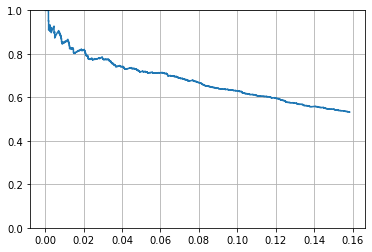

In [26]:
plt.plot(detections_df["Recall"],detections_df["Precision"])
plt.ylim([0,1])
plt.grid()

In [27]:
compute_ap(detections_df["Recall"].values, detections_df["Precision"].values)

0.10801317600914442